<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/video_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


In [2]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
filepath = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' # @param {type: "string"}
!ls -l $filepath

Mounted at /content/drive
-r-------- 1 root root 1425830568 Nov 16  2017 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi


In [3]:
video = media.read_video(filepath)

In [4]:
# Compress the video with default settings (H.264 codec)
COMPRESSION_BIT_RATES = {500_000, 200_000, 100_000}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))

3234958
1297732
651944


In [5]:
# Save the compressed video to a file
with open('/tmp/subject1_500_000.mp4', 'wb') as f:
    f.write(compressed_data[500_000])
with open('/tmp/subject1_200_000.mp4', 'wb') as f:
    f.write(compressed_data[200_000])
with open('/tmp/subject1_100_000.mp4', 'wb') as f:
    f.write(compressed_data[100_000])

In [6]:
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_500_000.mp4')
compressed_video_2 = media.read_video('/tmp/subject1_200_000.mp4')
compressed_video_3 = media.read_video('/tmp/subject1_100_000.mp4')
videos = {'Original': video[:10], 'Compressed_200_000': compressed_video_2[:10], 'Compressed_100_000': compressed_video_3[:10], 'Compressed_500_000': compressed_video[:10] }
media.show_videos(videos, fps=30)

1547


""

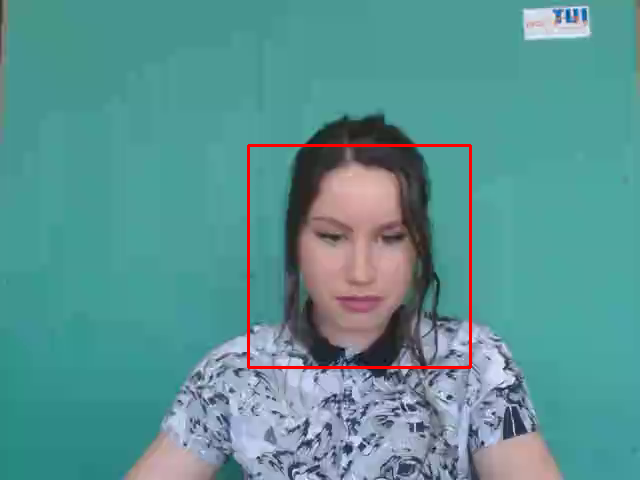

In [7]:
## Preprocessing - face detection and cropping
import cv2
import datetime
import math
from cv2 import dnn_superres

def read_video(video_file):
    """Reads a video file, returns frames(T, H, W, 3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
      frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      frame = np.asarray(frame)
      frames.append(frame)
      success, frame = VidObj.read()
    return np.asarray(frames)

def face_detection(frame, use_larger_box=False, larger_box_coef=1.0):
  """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bounding box.
  """
  # Use OpenCV's Haar Cascade algorithm implementation for face detection
  # This should only utilize the CPU
  detector = cv2.CascadeClassifier('/content/drive/MyDrive/research_project/DATASETS/haarcascade_frontalface_default.xml')

  # Computed face_zone(s) are in the form [x_coord, y_coord, width, height]
  # (x,y) corresponds to the top-left corner of the zone to define using
  # the computed width and height.
  face_zone = detector.detectMultiScale(frame)

  if len(face_zone) < 1:
    print("ERROR: No Face Detected")
    face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
  elif len(face_zone) >= 2:
    # Find the index of the largest face zone
    # The face zones are boxes, so the width and height are the same
    max_width_index = np.argmax(face_zone[:, 2])  # Index of maximum width
    face_box_coor = face_zone[max_width_index]
    print("Warning: More than one faces are detected. Only cropping the biggest one.")
  else:
    face_box_coor = face_zone[0]
  if use_larger_box:
    face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
    face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
    face_box_coor[2] = larger_box_coef * face_box_coor[2]
    face_box_coor[3] = larger_box_coef * face_box_coor[3]
  return face_box_coor

def superres(frame, model_path, model_name, scale):
  """Super resolution using DNN.

     Args:
       frames(np.array): Video frames.
       model_path(str): Path to the pre-trained model.
       model_name(str): Name of the model.
       scale(int): Scale factor.
     Returns:
        upscaled_frames(list[np.array(float)]): Upscaled frames
  """
  # Create a Super Resolution object
  sr = dnn_superres.DnnSuperResImpl_create()

  # Read the pre-trained model
  sr.readModel(model_path)

  # Set the model and scale
  sr.setModel(model_name, scale)

  # Upscale the image
  upscaled_frame = sr.upsample(frame)
  return upscaled_frame

def crop_face_resize(frames, use_face_detection,  use_larger_box, larger_box_coef, use_dynamic_detection,
                         detection_freq, use_median_box, width, height,
                     res_model_path, model_name, scale, denoise=False, upscale=False):
  """Crop face and resize frames.

     Args:
       frames(np.array): Video frames.
       use_face_detection(bool):  Whether crop the face.
       use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
       detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
       width(int): Target width for resizing.
       height(int): Target height for resizing.
       use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
       larger_box_coef(float): the coefficient of the larger region(height and weight)
                             the middle point of the detected region will stay still during the process of enlarging.
     Returns:
        resized_frames(list[np.array(float)]): Resized and cropped frames
  """
  # Face Cropping
  if use_dynamic_detection:
    num_dynamic_det = math.ceil(frames.shape[0] / detection_freq)
  else:
    num_dynamic_det = 1
  face_region_all = []
  # Perform face detection by num_dynamic_det" times.
  for idx in range(num_dynamic_det):
    if use_face_detection:
       face_region_all.append(face_detection(frames[detection_freq * idx], use_larger_box, larger_box_coef))
    else:
       face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
  if use_median_box:
     # Generate a median bounding box based on all detected face regions
     face_region_median = np.median(np.asarray(face_region_all, dtype='int'), axis=0).astype('int')
  print(np.asarray(face_region_all, dtype='int'))

  # Frame Resizing
  #resized_frames = np.zeros((frames.shape[0], height, width, 3))
  resized_frames = []
  for i in range(0, frames.shape[0]):
    frame = frames[i]
    if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
      reference_index = i // detection_freq
    else:  # use the first region obtrained from the first frame.
      reference_index = 0
    if use_face_detection:
      if use_median_box:
         face_region = face_region_median
      else:
         face_region = np.asarray(face_region_all, dtype='int')[reference_index]
      frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
         max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]
      if upscale:
        # Apply super resolution
        frame = superres(frame, res_model_path, model_name, scale)

    # Resize the frame
    resized_frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
    resized_frames.append(resized_frame)

  # denoise the resized frames
  if denoise:
    for i in range(0, frames.shape[0]):
      # To remove compression noise from an image using OpenCV
      # "fastNlMeansDenoising" or "fastNlMeansDenoisingMulti"
      # function may be more suitable for removing compression artifacts.
      # "fastNlMeansDenoising" implements the Non-Local Means (NLM) denoising
      # algorithm; Considers similar pixel neighborhoods across the
      # image to reduce noise while preserving edges and details.
      # "fastNlMeansDenoisingMulti" considers similar pixels across
      # multiple frames to denoise.
      # Other methods (less effective for compression noise):
      #    Median filtering: Can be used for basic smoothing but might blur edges.
      #    Gaussian blur: May help with some noise but can also blur details.
      #    Bilateral filtering: Preserves edges better than Gaussian blur but
      #    might not be as effective for compression noise.
      frame = resized_frames[i]
      temporalWindowSize = 3  # Number of adjacent frames to use (must be odd)
      if i in range(2,  frames.shape[0] - 2):
          h = 5  # Filter strength for luminance
          hColor = 5  # Filter strength for color
          templateWindowSize = 7 # Size of the template patch used for searching similar pixels
          searchWindowSize = 21 # Size of the search window to find similar pixels
          # Apply fastNlMeansDenoisingColoredMulti, which considers frames before and after the current
          # frame to denoise.
          start_pos = i - 2
          end_pos = i + 2
          #print("start_pos: " + str(start_pos) + ", end_pos: " + str(end_pos))
          resized_frames[i] = cv2.fastNlMeansDenoisingColoredMulti(
            resized_frames, i, temporalWindowSize, h, hColor, templateWindowSize, searchWindowSize)
          if i % 10 == 0:
            print("processed " + str(i))
            print(datetime.datetime.now().strftime("%H:%M:%S"))
      else:
          # Apply fastNlMeansDenoisingColored, which considers similar regions within the frame
          # to denoise.
          resized_frames[i] = cv2.fastNlMeansDenoisingColored(frame, None, 5, 5, 7, 21)

  return np.array(resized_frames)

video_file = '/tmp/subject1_200_000.mp4' # @param{type: "string"}
cropped_and_resized_file = '/tmp/subject1_200_000_cropped_and_resized.mp4' # @param{type: "string"}
frames = read_video(video_file)
print(len(frames))
face_box_coor = face_detection(frames[1], use_larger_box=True, larger_box_coef=1.5)
new_frame = cv2.rectangle(frames[0], (face_box_coor[0], face_box_coor[1]), (face_box_coor[0] + face_box_coor[2], face_box_coor[1] + face_box_coor[3]), (255, 0, 0), 2)
media.show_image(new_frame)

[[248 145 222 222]]


Original,Denoised Multi,Denoised,Bilateral,Gaussian blur,Sharpened

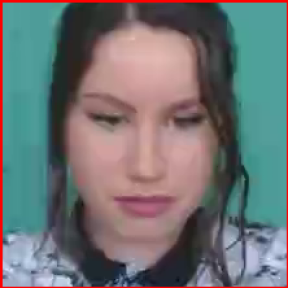
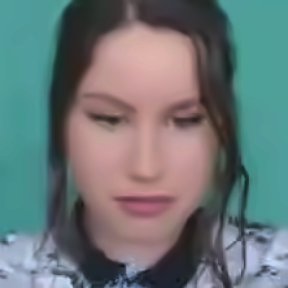
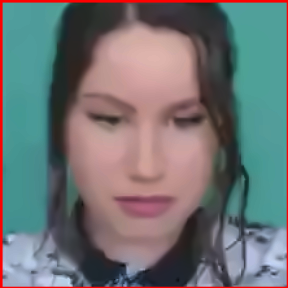
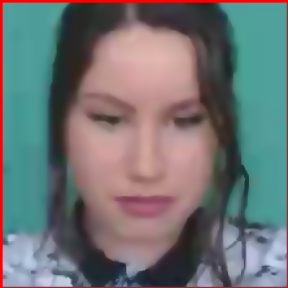
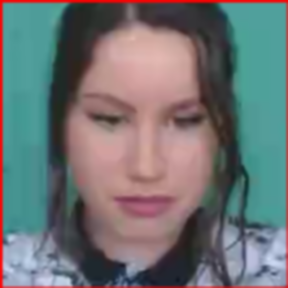
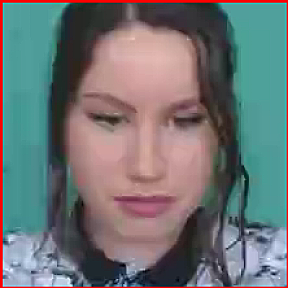

In [8]:
# Specify the path to the pre-trained model
MODEL_PATH = "/content/drive/MyDrive/research_project/vsr_model/EDSR_x4.pb"  # @param {type:"string"}
MODEL_NAME = "edsr" # @param {type: "string"}
SCALE = 4 # @param {type: "integer"}
HEIGHT = 288 # @param {type: "integer"}
WIDTH = 288 # @param {type: "integer"}
NUM_FRAMES = 150 # @param {type: "integer"}
resized_frames1 = crop_face_resize(frames, use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=False, upscale=False)

import cv2

for frame in resized_frames1[:1]:
  #  Reduce blockiness
  # Apply Gaussian Blur
  blurred = cv2.GaussianBlur(frame, (5, 5), 0)
  #blurred = cv2.GaussianBlur(frame, (7, 7), 2)
  # Apply Bilateral Filter (preserves edges)
  bilateral = cv2.bilateralFilter(frame, 9, 75, 75)
  #bilateral = cv2.bilateralFilter(frame, 9, 18, 18)
  # Reduce noisy edges
  denoised = cv2.fastNlMeansDenoisingColored(frame, None, 5, 5, 7, 21)
  # Sharpen
  sharpened = cv2.addWeighted(frame, 2.5, blurred, -1.5, 0)
  # denoised multi
  # Parameters for denoising
  temporalWindowSize = 3  # Number of adjacent frames to use (must be odd)
  h = 5  # Filter strength for luminance
  hColor = 5  # Filter strength for color
  templateWindowSize = 7 # Size of the template patch used for searching similar pixels
  searchWindowSize = 21 # Size of the search window to find similar pixels
  # Apply fastNlMeansDenoisingColoredMulti
  denoised_multi = cv2.fastNlMeansDenoisingColoredMulti(
    resized_frames1[:11], 5, temporalWindowSize, h, hColor, templateWindowSize, searchWindowSize)

images = {
    'Original': frame,
    'Denoised Multi': denoised_multi,
    'Denoised': denoised,
    'Bilateral': bilateral,
    'Gaussian blur': blurred,
    'Sharpened': sharpened}
media.show_images(images)


In [9]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Denoising...")
resized_frames2 = crop_face_resize(frames[:150], use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=True, upscale=False)
print("Done...")
print(datetime.datetime.now().strftime("%H:%M:%S"))
#print("Upscaling...")
#resized_frames3 = crop_face_resize(frames[:10], use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=False, upscale=True)
#print(datetime.datetime.now().strftime("%H:%M:%S"))

videos = {'Original resized': resized_frames1, 'Denoised': resized_frames2[:150]}
#videos = {'Original resized': resized_frames1[:20], 'Denoised': resized_frames2[:20], 'Upscaled': resized_frames3}
media.show_videos(videos, fps=30)

00:22:04
Denoising...
[[248 145 222 222]]
processed 10
00:22:17
processed 20
00:22:30
processed 30
00:22:44
processed 40
00:22:58
processed 50
00:23:11
processed 60
00:23:25
processed 70
00:23:38
processed 80
00:23:52
processed 90
00:24:06
processed 100
00:24:19
processed 110
00:24:33
processed 120
00:24:46
processed 130
00:25:00
processed 140
00:25:13
Done...
00:25:23


In [ ]:
import cv2
import os
import shutil


def frames_to_video(frames, output_path, fps=30):
    """Converts a sequence of frames to an MPEG4 video.

    Args:
        frames: A list of frames (numpy arrays) to be converted to a video.
        output_path: Name of the output video file (e.g., 'output.mp4').
        fps: Frames per second for the output video.
    """

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MPEG-4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_writer.write(frame_rgb)

    video_writer.release()

BASE_PATH = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_150_1_test' # @param{type: "string"}
PREPROCESSED_PATH = '/content/drive/MyDrive/research_project/data/preprocessed/DATASET_150_1_test' # @param{type: "string"}
FILE_NAME = 'vid.mp4' # @param{type: "string"}
print("Preprocessing data...")
print("Base path: " + BASE_PATH)
print("Preprocessed path: " + PREPROCESSED_PATH)
dirnames = os.listdir(BASE_PATH)
if not os.path.isdir(PREPROCESSED_PATH):
  os.mkdir(PREPROCESSED_PATH)
for dirname in dirnames:
  if not os.path.isdir(os.path.join(PREPROCESSED_PATH, dirname)):
    os.mkdir(os.path.join(PREPROCESSED_PATH, dirname))
    for filename in os.listdir(os.path.join(BASE_PATH, dirname)):
      if filename.endswith('.mp4'):
        video = media.read_video(os.path.join(BASE_PATH, dirname, filename))
        preprocessed_data = crop_face_resize(video, use_face_detection=True,  use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, detection_freq=32, use_median_box=False, width=WIDTH, height=HEIGHT, res_model_path=MODEL_PATH, model_name=MODEL_NAME, scale=SCALE, denoise=True, upscale=False)
        print("Writing " + os.path.join(PREPROCESSED_PATH, dirname, 'vid.mp4'))
        frames_to_video(preprocessed_data, os.path.join(PREPROCESSED_PATH, dirname, 'vid.mp4'))
      else:
        shutil.copy(os.path.join(BASE_PATH, dirname, filename), os.path.join(PREPROCESSED_PATH, dirname, filename))
print("All files processed")


Preprocessing data...
Base path: /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_150_1_test
Preprocessed path: /content/drive/MyDrive/research_project/data/preprocessed/DATASET_150_1_test
[[181  76 280 280]]
processed 10
00:28:02
processed 20
00:28:33
